In [1]:
# !pip install sidrapy
import sidrapy
import pandas as pd

In [2]:
## Coleta dados

# Dados do INPC usando API do Sidra/IBGE
dados_indice = sidrapy.get_table(table_code = '1736',
                             territorial_level = '1',
                             ibge_territorial_code = 'all',
                             variable = '2289',
                             period = 'all',
                             header = 'n')

# Rendimento médio nominal de todos os trabalhos habitualmente recebidos por mês (R$)
raw_rendimento = sidrapy.get_table(table_code = '6390',
                             territorial_level = '1',
                             ibge_territorial_code = 'all',
                             variable = '5929',
                             period = 'all',
                             header = 'n')

In [3]:
dados_indice

,NC,NN,MC,MN,V,D1C,D1N,D2C,D2N,D3C,D3N
0,1,Brasil,30,Número-índice,0.0000000055765,1,Brasil,197903,março 1979,2289,INPC - Número-índice (base: dezembro de 1993 =...
1,1,Brasil,30,Número-índice,0.0000000057689,1,Brasil,197904,abril 1979,2289,INPC - Número-índice (base: dezembro de 1993 =...
2,1,Brasil,30,Número-índice,0.0000000058704,1,Brasil,197905,maio 1979,2289,INPC - Número-índice (base: dezembro de 1993 =...
3,1,Brasil,30,Número-índice,0.0000000060465,1,Brasil,197906,junho 1979,2289,INPC - Número-índice (base: dezembro de 1993 =...
4,1,Brasil,30,Número-índice,0.0000000063705,1,Brasil,197907,julho 1979,2289,INPC - Número-índice (base: dezembro de 1993 =...
...,...,...,...,...,...,...,...,...,...,...,...
545,1,Brasil,30,Número-índice,7149.5500000000000,1,Brasil,202408,agosto 2024,2289,INPC - Número-índice (base: dezembro de 1993 =...
546,1,Brasil,30,Número-índice,7183.8700000000000,1,Brasil,202409,setembro 2024,2289,INPC - Número-índice (base: dezembro de 1993 =...
547,1,Brasil,30,Número-índice,7227.6900000000000,1,Brasil,202410,outubro 2024,2289,INPC - Número-índice (base: dezembro de 1993 =...
548,1,Brasil,30,Número-índice,7251.5400000000000,1,Brasil,202411,novembro 2024,2289,INPC - Número-índice (base: dezembro de 1993 =...


In [4]:
## Tratamento de dados

# INPC
inpc = (
     dados_indice
        .loc[0:,['V', 'D2C']]
        .rename(columns = {'V': 'indice',
                         'D2C': 'date'}
                )
        .assign(
            date  = lambda x: pd.to_datetime(x['date'],
                                              format = "%Y%m"),
            indice = lambda x: x['indice'].astype(float)
           )
        )

# Rendimento nominal
rendimento = (
     raw_rendimento
        .loc[0:,['V', 'D2C']]
        .rename(columns = {'V': 'value',
                         'D2C': 'date'}
                )
        .assign(
            date  = lambda x: pd.to_datetime(x['date'],
                                              format = "%Y%m"),
            value = lambda x: x['value'].astype(float)
           )
        )



In [5]:
## Juntar dados
dados = inpc.merge(rendimento, on = 'date')
dados

,indice,date,value
0,3536.17,2012-03-01,1424.0
1,3558.81,2012-04-01,1435.0
2,3578.38,2012-05-01,1437.0
3,3587.67,2012-06-01,1446.0
4,3603.10,2012-07-01,1458.0
...,...,...,...
148,7159.57,2024-07-01,3206.0
149,7149.55,2024-08-01,3228.0
150,7183.87,2024-09-01,3227.0
151,7227.69,2024-10-01,3255.0


In [6]:
# Deflacionando
dados["real"] = (dados["indice"].iloc[-1] / dados["indice"]) * dados["value"]

In [7]:
dados

,indice,date,value,real
0,3536.17,2012-03-01,1424.0,2920.163046
1,3558.81,2012-04-01,1435.0,2923.999848
2,3578.38,2012-05-01,1437.0,2912.061598
3,3587.67,2012-06-01,1446.0,2922.712189
4,3603.10,2012-07-01,1458.0,2934.346901
...,...,...,...,...
148,7159.57,2024-07-01,3206.0,3247.183454
149,7149.55,2024-08-01,3228.0,3274.048174
150,7183.87,2024-09-01,3227.0,3257.397417
151,7227.69,2024-10-01,3255.0,3265.740880


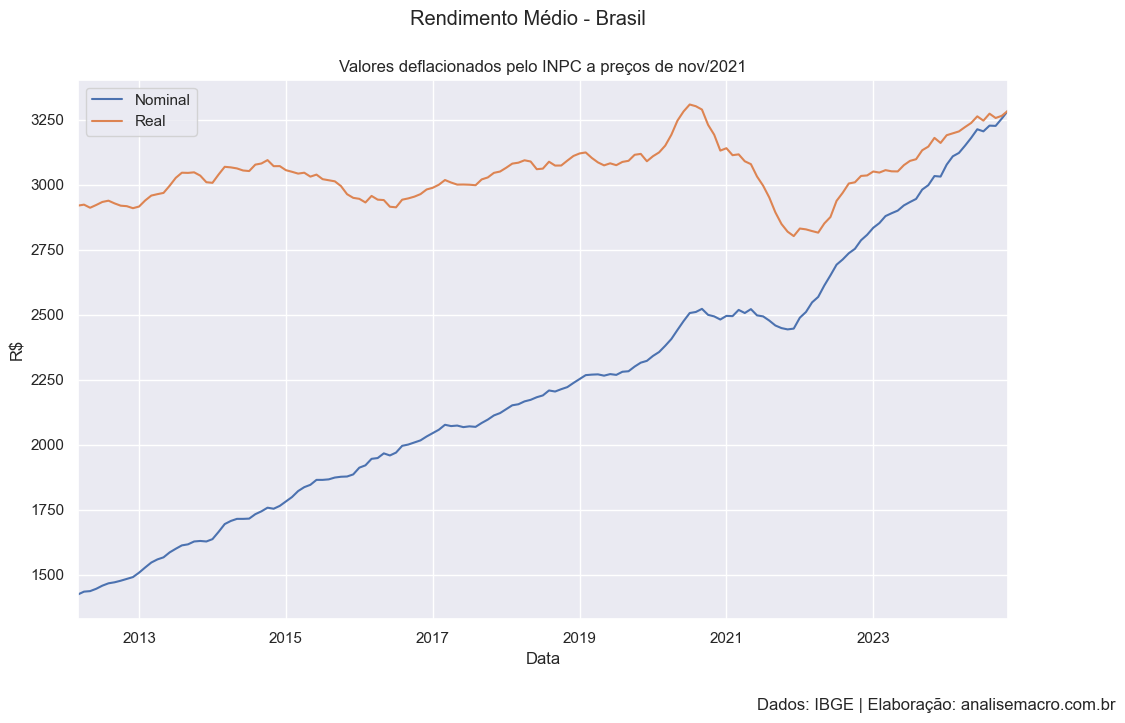

In [9]:
# Visualizando dados

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

axes = plt.gca() # cria um objeto de eixos

dados.plot(x = "date", y = ["value", "real"], kind = "line", ax = axes, figsize = (12,7)) # cria um gráfico de linha definindo os eixos e passando o objeto de eixos
plt.title("Valores deflacionados pelo INPC a preços de nov/2021") # define texto de título no gráfico criado
plt.suptitle("Rendimento Médio - Brasil") # define texto de subtítulo
plt.xlabel("Data")  # define texto no eixo X
plt.ylabel("R$")  # define texto no eixo Y
plt.legend(["Nominal", "Real"])  # define nome das séries na legenda
plt.figtext(   # adiciona texto de fonte (caption) nas coordenadas x e y
    x = 0.99, 
    y = -0.02,
    s = "Dados: IBGE | Elaboração: analisemacro.com.br", 
    horizontalalignment = "right"
    )

plt.show()

## Exercícios Extras

Legal, vamos criar 10 exercícios do básico ao avançado para você praticar a deflação de dados utilizando Python:

**Exercício 1**:
- Crie uma função para coletar dados do INPC usando a API do Sidra/IBGE com diferentes parâmetros de período.
- Descrição: Use a função `sidrapy.get_table` e modifique os parâmetros de período para coletar dados específicos.

**Exercício 2**:
- Modifique o código de coleta de dados para filtrar apenas um território específico do IBGE.
- Descrição: Ajuste o parâmetro `ibge_territorial_code` para coletar dados de um único território.

**Exercício 3**:
- Crie uma função que faça o tratamento dos dados do INPC e retorne um DataFrame com as colunas `date` e `indice`.
- Descrição: Implemente a transformação de data e conversão de tipos utilizando `pandas`.

**Exercício 4**:
- Crie uma função que junte os dados do INPC e do rendimento nominal em um único DataFrame.
- Descrição: Use a função `merge` do `pandas` para unir os DataFrames pela coluna `date`.

**Exercício 5**:
- Implemente uma função que deflacione os dados de rendimento nominal utilizando a fórmula fornecida.
- Descrição: Calcule a coluna `real` com base na fórmula `(dados["indice"].iloc[-1] / dados["indice"]) * dados["value"]`.

**Exercício 6**:
- Modifique a função de visualização de dados para criar gráficos de linha personalizados com diferentes parâmetros de estilo.
- Descrição: Utilize diferentes estilos do seaborn para personalizar o gráfico.

**Exercício 7**:
- Crie um gráfico de barras comparando os valores nominais e reais para um determinado ano.
- Descrição: Utilize a função `plot.bar` do `pandas` para criar o gráfico.

**Exercício 8**:
- Implemente uma função que normalize os dados de rendimento nominal e real, ajustando-os para um intervalo de 0 a 1.
- Descrição: Utilize a técnica de normalização min-max.

**Exercício 9**:
- Crie uma função que calcule a média e o desvio padrão dos rendimentos nominais e reais.
- Descrição: Utilize as funções `mean` e `std` do `pandas`.

**Exercício 10**:
- Implemente uma análise de sensibilidade dos dados deflacionados alterando o valor de referência do índice (data base).
- Descrição: Permita que o usuário altere o valor de `dados["indice"].iloc[-1]` para uma data específica e analise como isso afeta os valores reais.

Esses exercícios devem ajudar você a praticar e aprofundar seus conhecimentos na deflação de dados utilizando Python! Se precisar de mais alguma coisa, estou por aqui.